In [1]:
import tensorflow as tf
import tensorflow.contrib.layers as tf_layers
import cv2
import numpy as np
import shutil
import os
from matplotlib import pyplot as plt

In [14]:
data_path = "../data/"
processed_data_path = "../processed-data/"
model_saver_path = "../model/"

classes = ["grass", "lake", "sun"]
num_classes = len(classes)
X_width, X_height, X_channel = 32, 32, 3
epochs = 50
batch_size = 2
learning_rate = 0.0001

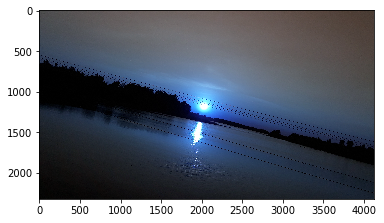

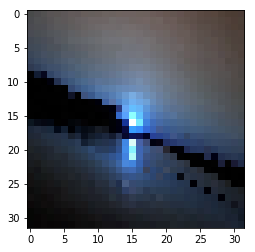

In [3]:
# clean processed-data folder
shutil.rmtree(processed_data_path)
os.mkdir(processed_data_path)

# preprocess data
for counter, label in enumerate(classes):
    os.mkdir(processed_data_path + label)
    for i in range(10):
        # create a relative path 
        img_path = label + "/" + label + " (" + str(i+1) + ").jpg"

        # load image
        img = cv2.imread(data_path + img_path, cv2.IMREAD_COLOR)
        if i >= 9 and counter >= num_classes - 1:
            plt.imshow(img)
            plt.show()

        # resize image
        img = cv2.resize(img, (X_width, X_height))
        if i >= 9 and counter >= num_classes - 1:
            plt.imshow(img)
            plt.show()
        
        # save resized image into processed-data folder
        cv2.imwrite(processed_data_path + img_path, img)


In [4]:
# create dataset for training and testing
# traning from image (1) -> image (7)
# testing from image (8) -> image (10)

train_set = np.array([np.array([(label + "/" + label + " (" + str(i+1) + ").jpg") for i in range(7)]) for label in classes])
train_set = train_set.flatten()
np.random.shuffle(train_set)
print(train_set)

test_set = np.array([np.array([(label + "/" + label + " (" + str(i+1) + ").jpg") for i in range(7, 10)]) for label in classes])
test_set = test_set.flatten()
np.random.shuffle(test_set)
print(test_set)

['lake/lake (2).jpg' 'sun/sun (3).jpg' 'sun/sun (1).jpg' 'sun/sun (6).jpg'
 'grass/grass (6).jpg' 'sun/sun (5).jpg' 'sun/sun (4).jpg'
 'grass/grass (3).jpg' 'grass/grass (5).jpg' 'grass/grass (4).jpg'
 'grass/grass (7).jpg' 'sun/sun (7).jpg' 'lake/lake (4).jpg'
 'lake/lake (6).jpg' 'lake/lake (3).jpg' 'sun/sun (2).jpg'
 'grass/grass (2).jpg' 'grass/grass (1).jpg' 'lake/lake (5).jpg'
 'lake/lake (1).jpg' 'lake/lake (7).jpg']
['sun/sun (9).jpg' 'lake/lake (9).jpg' 'grass/grass (9).jpg'
 'grass/grass (8).jpg' 'lake/lake (8).jpg' 'sun/sun (10).jpg'
 'grass/grass (10).jpg' 'sun/sun (8).jpg' 'lake/lake (10).jpg']


In [5]:
# setup config for session
config = tf.ConfigProto(log_device_placement=False)
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 1.

In [6]:
def cnn(X):    
    out = X #(32,32,3)
    out = tf_layers.conv2d(out, 16, 3, 1) #(32,32,16)
    out = tf_layers.max_pool2d(out, 3, 2) #(16,16,8)
    out = tf_layers.flatten(out) #(16*16*8,) 
    out = tf_layers.fully_connected(out, 100, biases_initializer=tf.initializers.zeros)
    out = tf_layers.fully_connected(out, num_classes, activation_fn=tf.nn.softmax)
    return out

In [7]:
sess = tf.Session(config=config)
X = tf.placeholder(tf.float32, [None, X_width, X_height, X_channel], name='input')
Y = tf.placeholder(tf.float32, [None, num_classes], name="y_true")

In [8]:
# create cnn model
y_pred = cnn(X)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_pred, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='cnn_adam')
train_op = optimizer.minimize(loss_op)

# Evaluate model
correct_pred = tf.equal(tf.argmax(y_pred, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [9]:
# Make monitor from tensor board
summary_train = tf.summary.merge([tf.summary.scalar("loss_op", loss_op), tf.summary.scalar("accuracy", accuracy)])
tf_writer = tf.summary.FileWriter(model_saver_path, sess.graph)

In [10]:
# init global vars
sess.run(tf.global_variables_initializer())
# create saver object
saver = tf.train.Saver(tf.trainable_variables(), max_to_keep=None)

In [11]:
def onehot(i):
    zeros = [0]*num_classes
    zeros[i] = 1
    return np.array(zeros)

In [15]:
def getBatchNext(d_set):
    batch = 0
    while True:
        paths = d_set[batch * batch_size : (batch + 1) * batch_size]
        if len(paths) <= 0 :
            break;
        inputs = np.array([cv2.imread(processed_data_path + p, cv2.IMREAD_COLOR) / 255 for p in paths])
        labels = np.array([onehot(classes.index(p.split('/', 1)[0])) for p in paths])
        yield batch, paths, inputs, labels
        batch += 1

In [13]:
print("TRAINING...")
shutil.rmtree(model_saver_path)
summ_counter = 0
for epoch in range(1, epochs + 1): 
    print("===== Epoch {}: =====".format(epoch))
    loss = 0
    acc = 0
    for batch, paths, inputs, labels in getBatchNext(train_set):
        
        # run training
        _loss, _acc, summ, _ = sess.run([loss_op, accuracy, summary_train, train_op], feed_dict={X: inputs, Y: labels})
        loss += _loss
        acc += _acc
        
        # summary data to tensor board
        tf_writer.add_summary(summ, summ_counter)
        summ_counter += 1
        
        # Display if neccessary
        # print("Batch {}: Loss {} - Acc {}".format(batch, _loss, _acc))
        
    print("""|
| loss_avg {} - acc_avg {}
|""".format(loss / (batch + 1), acc / (batch + 1)))
    
    # Save model each 10 epochs
    if epoch % 10 == 0 :
        saver.save(sess, model_saver_path + "model_{}.ckpt".format(epoch))

===== Epoch 1: =====
|
| loss_avg 1.1429238644513218 - acc_avg 0.13636363636363635
|
===== Epoch 2: =====
|
| loss_avg 1.0237023505297573 - acc_avg 0.7272727272727273
|
===== Epoch 3: =====
|
| loss_avg 0.9778214693069458 - acc_avg 0.5454545454545454
|
===== Epoch 4: =====
|
| loss_avg 0.9525920911268755 - acc_avg 0.5454545454545454
|
===== Epoch 5: =====
|
| loss_avg 0.9157173741947521 - acc_avg 0.7272727272727273
|
===== Epoch 6: =====
|
| loss_avg 0.876250608400865 - acc_avg 0.9545454545454546
|
===== Epoch 7: =====
|
| loss_avg 0.8393492590297352 - acc_avg 1.0
|
===== Epoch 8: =====
|
| loss_avg 0.804552511735396 - acc_avg 1.0
|
===== Epoch 9: =====
|
| loss_avg 0.7696646181019869 - acc_avg 1.0
|
===== Epoch 10: =====
|
| loss_avg 0.740672382441434 - acc_avg 1.0
|
INFO:tensorflow:../model/model_10.ckpt is not in all_model_checkpoint_paths. Manually adding it.
===== Epoch 11: =====
|
| loss_avg 0.7123863155191595 - acc_avg 1.0
|
===== Epoch 12: =====
|
| loss_avg 0.6892485889521512 

In [23]:
print("TESTING...")
saver.restore(sess, model_saver_path + "model_{}.ckpt".format(epochs))
loss = 0
acc = 0
for batch, paths, inputs, labels in getBatchNext(test_set):
    _loss, _acc, _y_pred = sess.run([loss_op, accuracy, y_pred], feed_dict={X: inputs, Y: labels})
    loss += _loss
    acc += _acc
    print("y_true: {} - y_pred {}".format(np.argmax(_y_pred, axis=1), np.argmax(labels, axis=1)))
    
print("""|
| loss_avg {} - acc_avg {}
|""".format(loss / (batch + 1), acc / (batch + 1)))

TESTING...
INFO:tensorflow:Restoring parameters from ../model/model_50.ckpt
y_true: [2 1] - y_pred [2 1]
y_true: [0 0] - y_pred [0 0]
y_true: [1 2] - y_pred [1 2]
y_true: [0 2] - y_pred [0 2]
y_true: [1] - y_pred [1]
|
| loss_avg 0.6174475312232971 - acc_avg 1.0
|
